<a href="https://colab.research.google.com/github/SophyyCC/GEOG761-Project/blob/main/vs30_chch_extraction_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ============================================================================
# CELL 1: Install Required Packages
# ============================================================================

print("Installing required packages...")
!pip install -q rasterio geopandas xarray netCDF4 matplotlib

print("✓ All packages installed!")
print("Note: If you see any warnings, you can ignore them.")

Installing required packages...
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.3/22.3 MB 29.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 48.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 55.6 MB/s eta 0:00:00
✓ All packages installed!
Note: If you see any warnings, you can ignore them.


In [2]:
# ============================================================================
# CELL 2: Import Libraries and Configuration
# ============================================================================

from google.colab import files
import numpy as np
import rasterio
from rasterio.warp import reproject, Resampling
from rasterio.transform import from_bounds, from_origin
import xarray as xr
import matplotlib.pyplot as plt
import os

print("✓ Libraries imported successfully!")

# Configuration
CELL_SIZE = 25  # meters
TARGET_CRS = 'EPSG:2193'  # NZTM2000

# Christchurch bounds
CHCH_BOUNDS_LATLON = {
    'west': 172.50,
    'east': 172.80,
    'south': -43.60,
    'north': -43.45
}

NZTM_BOUNDS = {
    'west': 1560000,
    'south': 5170000,
    'east': 1585000,
    'north': 5190000
}

# Calculate grid dimensions
width = int((NZTM_BOUNDS['east'] - NZTM_BOUNDS['west']) / CELL_SIZE)
height = int((NZTM_BOUNDS['north'] - NZTM_BOUNDS['south']) / CELL_SIZE)

# VS30 processing parameters (from NZ Makefile)
WATER_VELOCITY = 180  # m/s for water/ocean areas
MIN_VS30 = 150  # Minimum VS30 value per Nick Horspool

print(f"\nConfiguration:")
print(f"  Grid resolution: {CELL_SIZE}m")
print(f"  Target CRS: {TARGET_CRS}")
print(f"  Grid dimensions: {width} x {height} = {width*height:,} cells")
print(f"  Christchurch bounds (lat/lon): {CHCH_BOUNDS_LATLON}")
print(f"  Christchurch bounds (NZTM): {NZTM_BOUNDS}")

✓ Libraries imported successfully!

Configuration:
  Grid resolution: 25m
  Target CRS: EPSG:2193
  Grid dimensions: 1000 x 800 = 800,000 cells
  Christchurch bounds (lat/lon): {'west': 172.5, 'east': 172.8, 'south': -43.6, 'north': -43.45}
  Christchurch bounds (NZTM): {'west': 1560000, 'south': 5170000, 'east': 1585000, 'north': 5190000}


In [3]:
# ============================================================================
# CELL 3: Upload VS30 File
# ============================================================================

print("="*60)
print("UPLOAD VS30 FILE")
print("="*60)
print("\nPlease upload ONE of the following VS30 files:")
print("  1. VS30_NZ.grd (New Zealand VS30 grid)")
print("  2. vs30_nz_gmt4_pixel.grd (NZ VS30 pixel grid)")
print("  3. global_vs30.grd (Global VS30 grid)")
print("\nThese are typically NetCDF/GMT grid files (.grd extension)")
print("\n👇 Click 'Choose Files' below and select your VS30 file:")
print("-"*60)

# Upload VS30 file
uploaded = files.upload()

if not uploaded:
    raise FileNotFoundError("No VS30 file uploaded. Please upload a .grd file.")

vs30_filename = list(uploaded.keys())[0]
file_size_mb = os.path.getsize(vs30_filename) / (1024 * 1024)

print(f"\n✓ Uploaded: {vs30_filename} ({file_size_mb:.2f} MB)")

UPLOAD VS30 FILE

Please upload ONE of the following VS30 files:
  1. VS30_NZ.grd (New Zealand VS30 grid)
  2. vs30_nz_gmt4_pixel.grd (NZ VS30 pixel grid)
  3. global_vs30.grd (Global VS30 grid)

These are typically NetCDF/GMT grid files (.grd extension)

👇 Click 'Choose Files' below and select your VS30 file:
------------------------------------------------------------


Saving global_vs30.grd to global_vs30.grd

✓ Uploaded: global_vs30.grd (581.92 MB)


In [4]:
# ============================================================================
# CELL 4: Process VS30 Data
# ============================================================================

print("\n" + "="*60)
print("PROCESSING VS30 DATA")
print("="*60)

vs30_nztm = None
method_used = None

# Try Method 1: Rasterio (for GeoTIFF and some GRD files)
print("\n[Method 1] Attempting to open with rasterio...")
try:
    with rasterio.open(vs30_filename) as src:
        print(f"  ✓ Successfully opened file")
        print(f"    CRS: {src.crs}")
        print(f"    Bounds: {src.bounds}")
        print(f"    Shape: {src.shape}")
        print(f"    Data type: {src.dtypes[0]}")

        # Crop to Christchurch region
        print(f"\n  Cropping to Christchurch region...")

        window = rasterio.windows.from_bounds(
            CHCH_BOUNDS_LATLON['west'],
            CHCH_BOUNDS_LATLON['south'],
            CHCH_BOUNDS_LATLON['east'],
            CHCH_BOUNDS_LATLON['north'],
            src.transform
        )

        # Read the data
        vs30_data_latlon = src.read(1, window=window)
        vs30_transform_latlon = rasterio.windows.transform(window, src.transform)

        print(f"    Cropped shape: {vs30_data_latlon.shape}")
        print(f"    Value range: {np.nanmin(vs30_data_latlon):.1f} to {np.nanmax(vs30_data_latlon):.1f}")

        # Apply NZ-specific processing
        print(f"\n  Applying NZ-specific processing...")
        vs30_processed = vs30_data_latlon.copy()
        vs30_processed[vs30_processed == 0] = WATER_VELOCITY
        vs30_processed[(vs30_processed > 0) & (vs30_processed < MIN_VS30)] = MIN_VS30
        vs30_processed[np.isnan(vs30_processed)] = WATER_VELOCITY

        print(f"    After processing: {np.nanmin(vs30_processed):.1f} to {np.nanmax(vs30_processed):.1f}")

        # Reproject to NZTM2000
        print(f"\n  Reprojecting to NZTM2000 at {CELL_SIZE}m resolution...")

        dst_transform = from_bounds(
            NZTM_BOUNDS['west'],
            NZTM_BOUNDS['south'],
            NZTM_BOUNDS['east'],
            NZTM_BOUNDS['north'],
            width,
            height
        )

        vs30_nztm = np.zeros((height, width), dtype=np.float32)

        reproject(
            source=vs30_processed,
            destination=vs30_nztm,
            src_transform=vs30_transform_latlon,
            src_crs='EPSG:4326',
            dst_transform=dst_transform,
            dst_crs=TARGET_CRS,
            resampling=Resampling.bilinear
        )

        # Post-processing
        vs30_nztm[vs30_nztm == 0] = WATER_VELOCITY
        vs30_nztm[(vs30_nztm > 0) & (vs30_nztm < MIN_VS30)] = MIN_VS30
        vs30_nztm[np.isnan(vs30_nztm)] = WATER_VELOCITY

        method_used = "rasterio"
        print(f"    ✓ Successfully processed with rasterio")

except Exception as e:
    print(f"  ✗ Rasterio method failed: {str(e)}")

    # Try Method 2: xarray (better for NetCDF/GMT GRD files)
    print("\n[Method 2] Attempting to open with xarray...")
    try:
        ds = xr.open_dataset(vs30_filename)

        print(f"  ✓ Successfully opened with xarray")
        print(f"    Dimensions: {dict(ds.dims)}")
        print(f"    Variables: {list(ds.variables.keys())}")

        # Find the VS30 variable
        possible_vars = ['vs30', 'z', 'Band1', 'data', 'elevation', 'variable']
        vs30_var = None

        for var in possible_vars:
            if var in ds.variables:
                vs30_var = var
                break

        if vs30_var is None:
            data_vars = [v for v in ds.data_vars if len(ds[v].dims) >= 2]
            if data_vars:
                vs30_var = data_vars[0]

        if vs30_var is None:
            raise ValueError(f"Could not identify VS30 variable. Available: {list(ds.data_vars)}")

        print(f"    Using variable: {vs30_var}")

        # Get coordinate names
        coords = list(ds.coords.keys())
        print(f"    Coordinates: {coords}")

        # Find lon/lat coordinates
        lon_names = ['x', 'lon', 'longitude']
        lat_names = ['y', 'lat', 'latitude']

        lon_coord = next((c for c in coords if any(n in c.lower() for n in lon_names)), coords[0])
        lat_coord = next((c for c in coords if any(n in c.lower() for n in lat_names)),
                        coords[1] if len(coords) > 1 else coords[0])

        print(f"    Using lon={lon_coord}, lat={lat_coord}")

        # Get coordinate values
        lon_vals = ds[lon_coord].values
        lat_vals = ds[lat_coord].values

        # Crop to Christchurch region
        print(f"\n  Cropping to Christchurch region...")

        # Handle both ascending and descending coordinate orders
        if lat_vals[0] < lat_vals[-1]:  # Ascending
            ds_cropped = ds.sel({
                lon_coord: slice(CHCH_BOUNDS_LATLON['west'], CHCH_BOUNDS_LATLON['east']),
                lat_coord: slice(CHCH_BOUNDS_LATLON['south'], CHCH_BOUNDS_LATLON['north'])
            })
        else:  # Descending
            ds_cropped = ds.sel({
                lon_coord: slice(CHCH_BOUNDS_LATLON['west'], CHCH_BOUNDS_LATLON['east']),
                lat_coord: slice(CHCH_BOUNDS_LATLON['north'], CHCH_BOUNDS_LATLON['south'])
            })

        vs30_data = ds_cropped[vs30_var].values

        # Handle different dimension orders
        if vs30_data.ndim > 2:
            vs30_data = vs30_data.squeeze()

        print(f"    Cropped shape: {vs30_data.shape}")
        print(f"    Value range: {np.nanmin(vs30_data):.1f} to {np.nanmax(vs30_data):.1f}")

        # Get cropped coordinates
        lons = ds_cropped[lon_coord].values
        lats = ds_cropped[lat_coord].values

        # Create transform
        if len(lons) > 1 and len(lats) > 1:
            lon_res = abs((lons[-1] - lons[0]) / (len(lons) - 1))
            lat_res = abs((lats[-1] - lats[0]) / (len(lats) - 1))
        else:
            lon_res = 0.001  # Default resolution
            lat_res = 0.001

        # Determine upper-left corner
        lon_min = min(lons[0], lons[-1]) if len(lons) > 1 else lons[0]
        lat_max = max(lats[0], lats[-1]) if len(lats) > 1 else lats[0]

        vs30_transform_latlon = from_origin(lon_min, lat_max, lon_res, lat_res)

        # Apply NZ processing
        print(f"\n  Applying NZ-specific processing...")
        vs30_processed = vs30_data.copy()
        vs30_processed[vs30_processed == 0] = WATER_VELOCITY
        vs30_processed[(vs30_processed > 0) & (vs30_processed < MIN_VS30)] = MIN_VS30
        vs30_processed[np.isnan(vs30_processed)] = WATER_VELOCITY

        print(f"    After processing: {np.nanmin(vs30_processed):.1f} to {np.nanmax(vs30_processed):.1f}")

        # Reproject to NZTM
        print(f"\n  Reprojecting to NZTM2000 at {CELL_SIZE}m resolution...")

        dst_transform = from_bounds(
            NZTM_BOUNDS['west'],
            NZTM_BOUNDS['south'],
            NZTM_BOUNDS['east'],
            NZTM_BOUNDS['north'],
            width,
            height
        )

        vs30_nztm = np.zeros((height, width), dtype=np.float32)

        reproject(
            source=vs30_processed,
            destination=vs30_nztm,
            src_transform=vs30_transform_latlon,
            src_crs='EPSG:4326',
            dst_transform=dst_transform,
            dst_crs=TARGET_CRS,
            resampling=Resampling.bilinear
        )

        # Post-processing
        vs30_nztm[vs30_nztm == 0] = WATER_VELOCITY
        vs30_nztm[(vs30_nztm > 0) & (vs30_nztm < MIN_VS30)] = MIN_VS30
        vs30_nztm[np.isnan(vs30_nztm)] = WATER_VELOCITY

        method_used = "xarray"
        print(f"    ✓ Successfully processed with xarray")

    except Exception as e2:
        print(f"  ✗ Xarray method also failed: {str(e2)}")
        raise RuntimeError("Could not process VS30 file with either method. Please check file format.")

# Verify we got data
if vs30_nztm is None:
    raise ValueError("VS30 processing failed - no data generated")

if np.all(vs30_nztm == WATER_VELOCITY):
    print("\n⚠ WARNING: All values are set to water velocity - check bounds and data coverage")

print(f"\n{'='*60}")
print("PROCESSING SUMMARY")
print(f"{'='*60}")
print(f"  Method used: {method_used}")
print(f"  Output shape: {vs30_nztm.shape}")
print(f"  Value range: {np.nanmin(vs30_nztm):.1f} to {np.nanmax(vs30_nztm):.1f} m/s")
print(f"  Mean: {np.nanmean(vs30_nztm):.1f} m/s")
print(f"  Median: {np.nanmedian(vs30_nztm):.1f} m/s")
print(f"  Non-water cells: {np.sum(vs30_nztm != WATER_VELOCITY):,} ({100*np.sum(vs30_nztm != WATER_VELOCITY)/(height*width):.1f}%)")


PROCESSING VS30 DATA

[Method 1] Attempting to open with rasterio...
  ✓ Successfully opened file
    CRS: None
    Bounds: BoundingBox(left=-180.00416666666666, bottom=-56.00416666666666, right=180.00416666666666, top=84.00416666666666)
    Shape: (16801, 43201)
    Data type: float32

  Cropping to Christchurch region...
    Cropped shape: (18, 36)
    Value range: 180.0 to 900.0

  Applying NZ-specific processing...
    After processing: 180.0 to 900.0

  Reprojecting to NZTM2000 at 25m resolution...
    ✓ Successfully processed with rasterio

PROCESSING SUMMARY
  Method used: rasterio
  Output shape: (800, 1000)
  Value range: 180.0 to 900.0 m/s
  Mean: 339.2 m/s
  Median: 239.2 m/s
  Non-water cells: 635,682 (79.5%)


In [5]:
# ============================================================================
# CELL 5: Save Processed VS30 Dataset
# ============================================================================

print("\n" + "="*60)
print("SAVING VS30 DATASET")
print("="*60)

# Create output filename
output_filename = 'vs30_christchurch_25m_nztm.tif'

# Prepare transform
dst_transform = from_bounds(
    NZTM_BOUNDS['west'],
    NZTM_BOUNDS['south'],
    NZTM_BOUNDS['east'],
    NZTM_BOUNDS['north'],
    width,
    height
)

# Save as GeoTIFF
print(f"\nSaving to: {output_filename}")
with rasterio.open(
    output_filename,
    'w',
    driver='GTiff',
    height=height,
    width=width,
    count=1,
    dtype=vs30_nztm.dtype,
    crs=TARGET_CRS,
    transform=dst_transform,
    compress='lzw'
) as dst:
    dst.write(vs30_nztm, 1)

file_size = os.path.getsize(output_filename) / (1024 * 1024)
print(f"✓ Saved successfully!")
print(f"  File: {output_filename}")
print(f"  Size: {file_size:.2f} MB")
print(f"  Format: GeoTIFF")
print(f"  CRS: {TARGET_CRS}")
print(f"  Resolution: {CELL_SIZE}m")


SAVING VS30 DATASET

Saving to: vs30_christchurch_25m_nztm.tif
✓ Saved successfully!
  File: vs30_christchurch_25m_nztm.tif
  Size: 2.23 MB
  Format: GeoTIFF
  CRS: EPSG:2193
  Resolution: 25m



CREATING VISUALIZATIONS


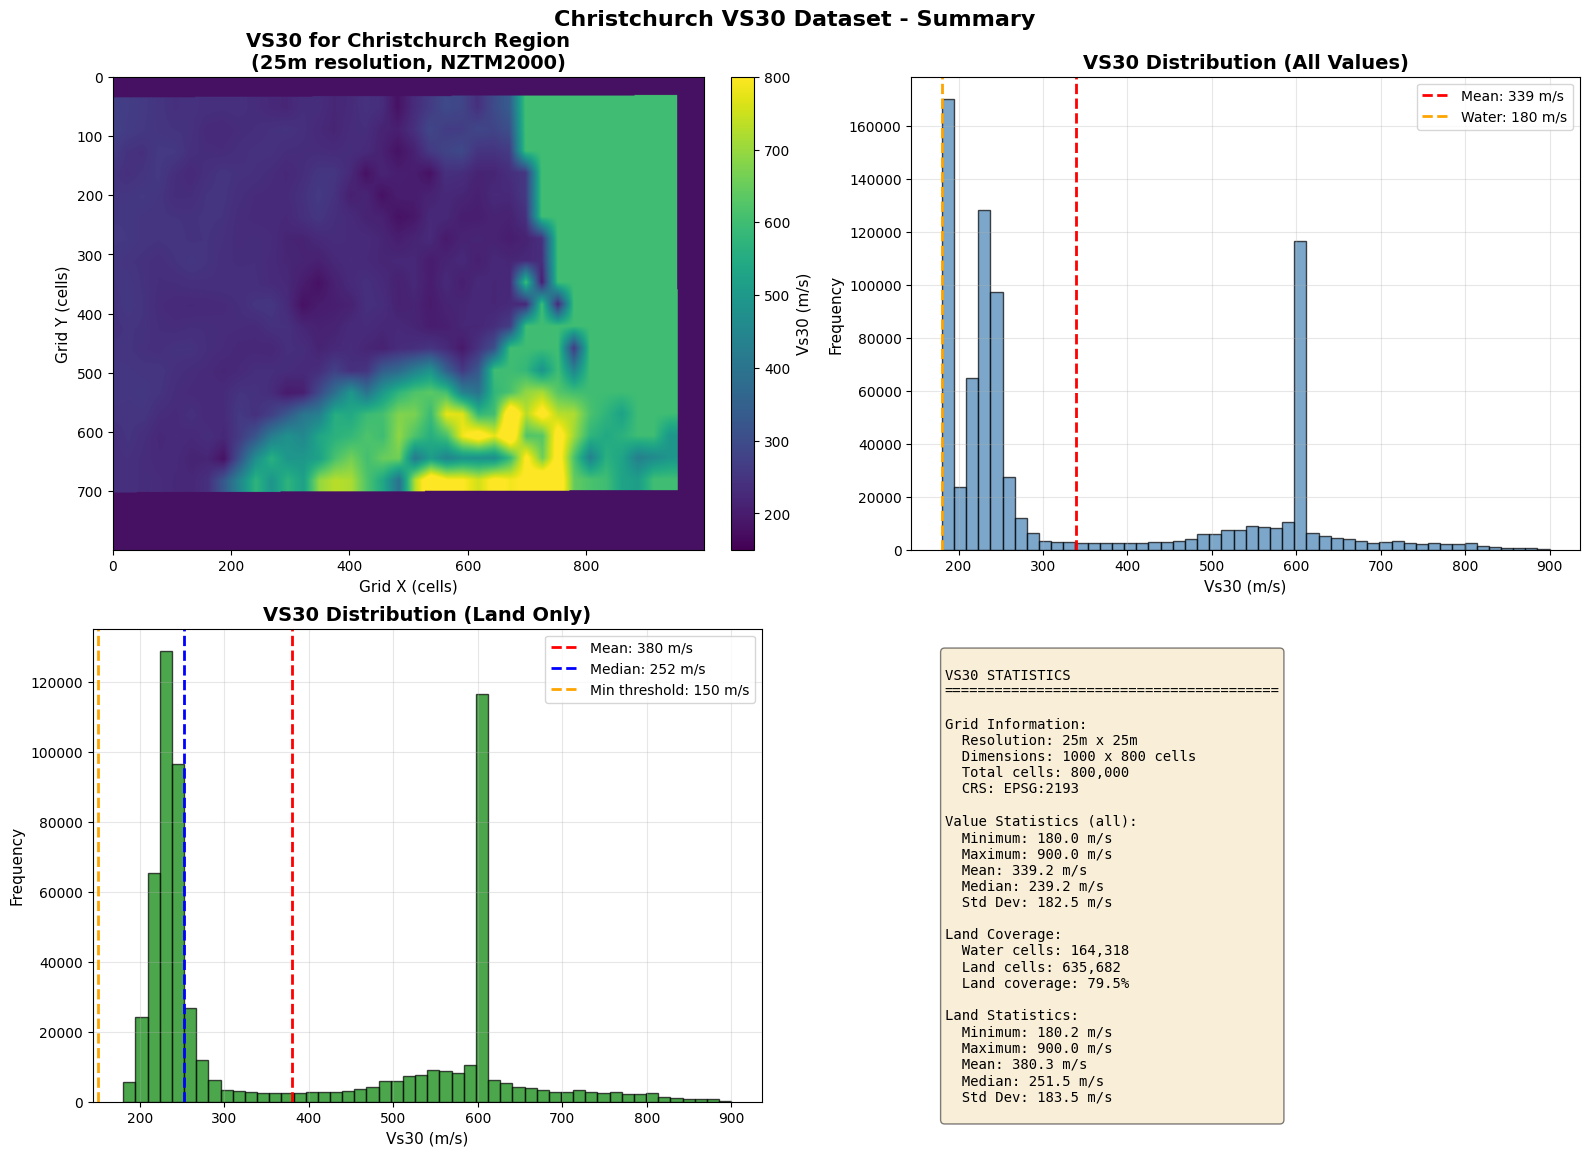


✓ Visualization saved to: vs30_christchurch_summary.png


In [6]:
# ============================================================================
# CELL 6: Visualize VS30 Data
# ============================================================================

print("\n" + "="*60)
print("CREATING VISUALIZATIONS")
print("="*60)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: VS30 Map
im1 = axes[0, 0].imshow(vs30_nztm, cmap='viridis', vmin=150, vmax=800)
axes[0, 0].set_title('VS30 for Christchurch Region\n(25m resolution, NZTM2000)',
                     fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Grid X (cells)', fontsize=11)
axes[0, 0].set_ylabel('Grid Y (cells)', fontsize=11)
cbar1 = plt.colorbar(im1, ax=axes[0, 0], fraction=0.046, pad=0.04)
cbar1.set_label('Vs30 (m/s)', fontsize=11)

# Plot 2: VS30 Histogram (all values)
axes[0, 1].hist(vs30_nztm.flatten(), bins=50, color='steelblue', alpha=0.7, edgecolor='black')
axes[0, 1].axvline(np.mean(vs30_nztm), color='red', linestyle='--', linewidth=2,
                   label=f'Mean: {np.mean(vs30_nztm):.0f} m/s')
axes[0, 1].axvline(WATER_VELOCITY, color='orange', linestyle='--', linewidth=2,
                   label=f'Water: {WATER_VELOCITY} m/s')
axes[0, 1].set_xlabel('Vs30 (m/s)', fontsize=11)
axes[0, 1].set_ylabel('Frequency', fontsize=11)
axes[0, 1].set_title('VS30 Distribution (All Values)', fontsize=14, fontweight='bold')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: VS30 Histogram (land only)
vs30_land = vs30_nztm[vs30_nztm != WATER_VELOCITY]
if len(vs30_land) > 0:
    axes[1, 0].hist(vs30_land.flatten(), bins=50, color='green', alpha=0.7, edgecolor='black')
    axes[1, 0].axvline(np.mean(vs30_land), color='red', linestyle='--', linewidth=2,
                       label=f'Mean: {np.mean(vs30_land):.0f} m/s')
    axes[1, 0].axvline(np.median(vs30_land), color='blue', linestyle='--', linewidth=2,
                       label=f'Median: {np.median(vs30_land):.0f} m/s')
    axes[1, 0].axvline(MIN_VS30, color='orange', linestyle='--', linewidth=2,
                       label=f'Min threshold: {MIN_VS30} m/s')
    axes[1, 0].set_xlabel('Vs30 (m/s)', fontsize=11)
    axes[1, 0].set_ylabel('Frequency', fontsize=11)
    axes[1, 0].set_title('VS30 Distribution (Land Only)', fontsize=14, fontweight='bold')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
else:
    axes[1, 0].text(0.5, 0.5, 'No land data available',
                    ha='center', va='center', fontsize=14)
    axes[1, 0].set_title('VS30 Distribution (Land Only)', fontsize=14, fontweight='bold')

# Plot 4: Statistics Summary
stats_text = f"""
VS30 STATISTICS
{'='*40}

Grid Information:
  Resolution: {CELL_SIZE}m x {CELL_SIZE}m
  Dimensions: {width} x {height} cells
  Total cells: {width*height:,}
  CRS: {TARGET_CRS}

Value Statistics (all):
  Minimum: {np.min(vs30_nztm):.1f} m/s
  Maximum: {np.max(vs30_nztm):.1f} m/s
  Mean: {np.mean(vs30_nztm):.1f} m/s
  Median: {np.median(vs30_nztm):.1f} m/s
  Std Dev: {np.std(vs30_nztm):.1f} m/s

Land Coverage:
  Water cells: {np.sum(vs30_nztm == WATER_VELOCITY):,}
  Land cells: {np.sum(vs30_nztm != WATER_VELOCITY):,}
  Land coverage: {100*np.sum(vs30_nztm != WATER_VELOCITY)/(height*width):.1f}%
"""

if len(vs30_land) > 0:
    stats_text += f"""
Land Statistics:
  Minimum: {np.min(vs30_land):.1f} m/s
  Maximum: {np.max(vs30_land):.1f} m/s
  Mean: {np.mean(vs30_land):.1f} m/s
  Median: {np.median(vs30_land):.1f} m/s
  Std Dev: {np.std(vs30_land):.1f} m/s
"""

axes[1, 1].text(0.05, 0.95, stats_text, transform=axes[1, 1].transAxes,
                fontsize=10, verticalalignment='top', fontfamily='monospace',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))
axes[1, 1].axis('off')

plt.suptitle('Christchurch VS30 Dataset - Summary', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.savefig('vs30_christchurch_summary.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Visualization saved to: vs30_christchurch_summary.png")

In [7]:
# ============================================================================
# CELL 7: Download Processed File
# ============================================================================

print("\n" + "="*60)
print("DOWNLOAD PROCESSED VS30 FILE")
print("="*60)

print(f"\nYour processed VS30 file is ready:")
print(f"  Filename: {output_filename}")
print(f"  Size: {file_size:.2f} MB")
print(f"  Format: GeoTIFF (compatible with QGIS, ArcGIS, Python)")
print(f"  Resolution: {CELL_SIZE}m")
print(f"  CRS: {TARGET_CRS} (NZTM2000)")
print(f"  Dimensions: {width} x {height} cells")

print(f"\nDownloading file...")
files.download(output_filename)

print(f"\n✓ Download initiated!")
print(f"\nYou can now use this file directly in your Random Forest model.")
print(f"Simply upload '{output_filename}' to your RF notebook and update FILE_PATHS:")
print(f"  FILE_PATHS['vs30'] = '{output_filename}'")


DOWNLOAD PROCESSED VS30 FILE

Your processed VS30 file is ready:
  Filename: vs30_christchurch_25m_nztm.tif
  Size: 2.23 MB
  Format: GeoTIFF (compatible with QGIS, ArcGIS, Python)
  Resolution: 25m
  CRS: EPSG:2193 (NZTM2000)
  Dimensions: 1000 x 800 cells



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


✓ Download initiated!

You can now use this file directly in your Random Forest model.
Simply upload 'vs30_christchurch_25m_nztm.tif' to your RF notebook and update FILE_PATHS:
  FILE_PATHS['vs30'] = 'vs30_christchurch_25m_nztm.tif'
